**Causality with A/B testing - Worked Examples**

Lakshmi GayatriAishwarya Adduri
NUID: 002738716

**Example 1:** Fast Food Marketing Campaign A\B Test
https://www.kaggle.com/datasets/chebotinaa/fast-food-marketing-campaign-ab-test

**Datacard**
* MarketID: unique identifier for market

* MarketSize: size of market area by sales
* LocationID: unique identifier for store location
* AgeOfStore: age of store in years
* Promotion: one of three promotions that were tested
* week: one of four weeks when the promotions were run
* SalesInThousands: sales amount for a specific LocationID, Promotion, and week

In [53]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats
from scipy.stats import shapiro

In [54]:
df = pd.read_csv("https://raw.githubusercontent.com/adduriAishwarya/Causality-A-B-Testing/main/WA_Marketing-Campaign.csv")
df.head()

,MarketID,MarketSize,LocationID,AgeOfStore,Promotion,week,SalesInThousands
0,1,Medium,1,4,3,1,33.73
1,1,Medium,1,4,3,2,35.67
2,1,Medium,1,4,3,3,29.03
3,1,Medium,1,4,3,4,39.25
4,1,Medium,2,5,2,1,27.81


In [55]:
df.describe(include='all')

,MarketID,MarketSize,LocationID,AgeOfStore,Promotion,week,SalesInThousands
count,548.000000,548,548.000000,548.000000,548.000000,548.000000,548.000000
unique,NaN,3,NaN,NaN,NaN,NaN,NaN
top,NaN,Medium,NaN,NaN,NaN,NaN,NaN
freq,NaN,320,NaN,NaN,NaN,NaN,NaN
mean,5.715328,NaN,479.656934,8.503650,2.029197,2.500000,53.466204
std,2.877001,NaN,287.973679,6.638345,0.810729,1.119055,16.755216
min,1.000000,NaN,1.000000,1.000000,1.000000,1.000000,17.340000
25%,3.000000,NaN,216.000000,4.000000,1.000000,1.750000,42.545000
50%,6.000000,NaN,504.000000,7.000000,2.000000,2.500000,50.200000
75%,8.000000,NaN,708.000000,12.000000,3.000000,3.250000,60.477500


In [56]:
unique_values_per_column = df.nunique()
print(unique_values_per_column)


MarketID             10
MarketSize            3
LocationID          137
AgeOfStore           25
Promotion             3
week                  4
SalesInThousands    517
dtype: int64


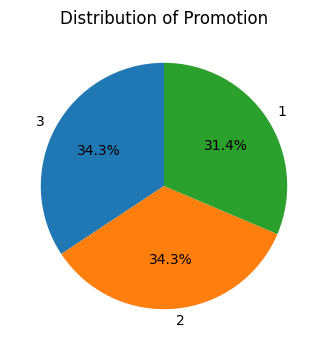

In [57]:
df["Promotion"].value_counts()

promotion_distribution = df["Promotion"].value_counts()

# Plotting the pie chart
plt.figure(figsize=(6, 4))
plt.pie(promotion_distribution, labels=promotion_distribution.index, autopct='%1.1f%%', startangle=90)
plt.title('Distribution of Promotion')
plt.show()


Given almost equal number of records for each promotion, let us find if atleast one of the promotions is better than other

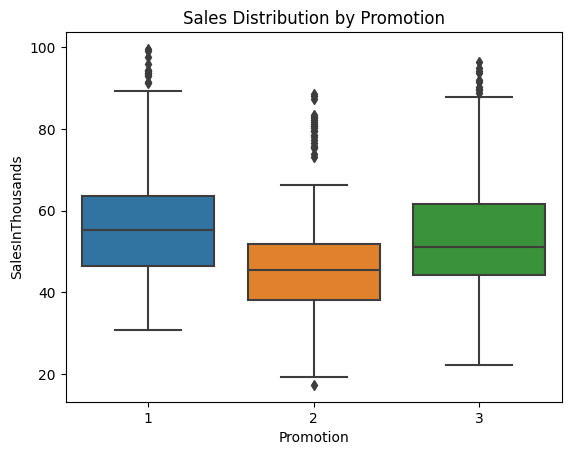

In [58]:
# Visualize sales distribution across promotions
sns.boxplot(x="Promotion", y="SalesInThousands", data=df)
plt.title("Sales Distribution by Promotion")
plt.show()

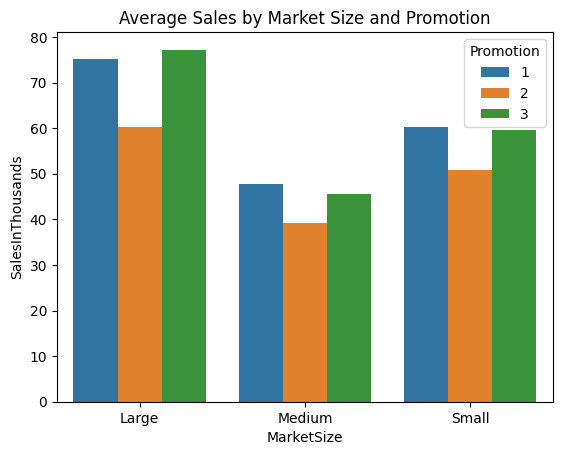

In [59]:
# Visualize average sales by MarketSize and Promotion
market_size_grouped = df.groupby(["MarketSize", "Promotion"])["SalesInThousands"].mean().reset_index()
sns.barplot(x="MarketSize", y="SalesInThousands", hue="Promotion", data=market_size_grouped)
plt.title("Average Sales by Market Size and Promotion")
plt.show()

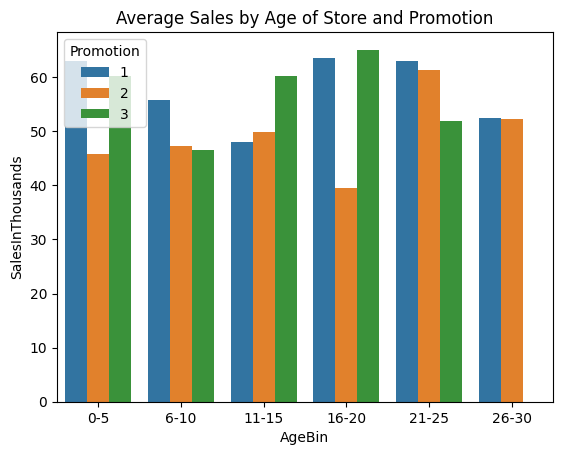

In [60]:
# Visualize average sales by AgeOfStore and Promotion (using age bins)
df["AgeBin"] = pd.cut(df["AgeOfStore"], bins=[0, 5, 10, 15, 20, 25, 30], labels=["0-5", "6-10", "11-15", "16-20", "21-25", "26-30"])
age_grouped = df.groupby(["AgeBin", "Promotion"])["SalesInThousands"].mean().reset_index()
sns.barplot(x="AgeBin", y="SalesInThousands", hue="Promotion", data=age_grouped)
plt.title("Average Sales by Age of Store and Promotion")
plt.show()

Lets check for correlation between columns

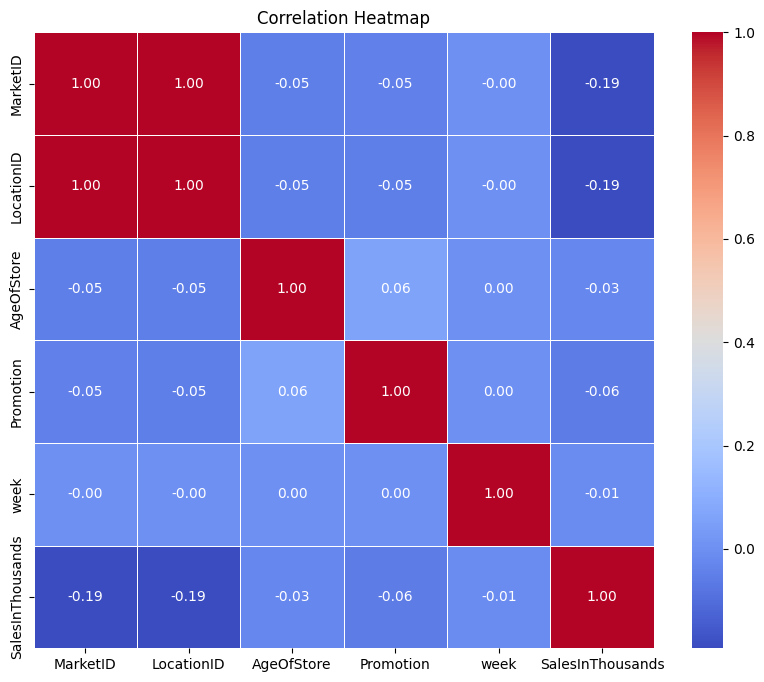

In [61]:
# Select the columns for the correlation matrix
selected_columns = ['MarketID', 'LocationID', 'AgeOfStore', 'Promotion', 'week', 'SalesInThousands']
# Create the correlation matrix
correlation_matrix = df[selected_columns].corr()


# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Heatmap')
plt.show()

From this we can see that SalesInThousands has very weak and negative correlation with all the variables

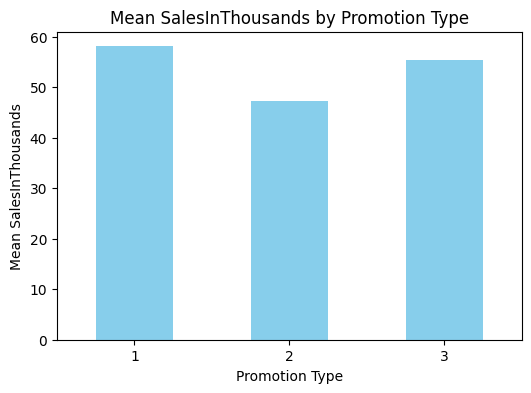

In [62]:
# Group by 'Promotion' and calculate the mean for 'SalesInThousands'
mean_sales_by_promotion = df.groupby('Promotion')['SalesInThousands'].mean()

# Plotting the bar graph
plt.figure(figsize=(6, 4))
mean_sales_by_promotion.plot(kind='bar', color='skyblue')
plt.title('Mean SalesInThousands by Promotion Type')
plt.xlabel('Promotion Type')
plt.ylabel('Mean SalesInThousands')
plt.xticks(rotation=0)
plt.show()

In [63]:
print(mean_sales_by_promotion)

Promotion
1    58.099012
2    47.329415
3    55.364468
Name: SalesInThousands, dtype: float64


Promotion has the highest mean of SalesInThousands amongst the three promotion types

**Hypothesis formulation:**

Null Hypothesis (H0): There is no statistical difference in terms of promotion types

Alternative Hypothesis (H1): At least one group is different from the others.

**Check for Normality and Homogeneity of Variance:**

In [64]:
for group in list(df["Promotion"].unique()):

    pvalue = shapiro(df.loc[df["Promotion"] == group, "SalesInThousands"])[1]

    print(group, 'p-value: %.4f' % pvalue)

3 p-value: 0.0000
2 p-value: 0.0000
1 p-value: 0.0000


H0 has been rejected. It does not exhibit a normal distribution.So, we have to go for non-parametric tests

# **Non-parametric Testing**

**Kruskal-Wallis Test:**

It is a non-parametric alternative to one-way ANOVA.
Used when comparing more than two independent groups.
Assesses whether there are statistically significant differences between the medians of different groups.




In [65]:
from scipy.stats import kruskal

resultK = kruskal(df[df['Promotion'] == 1]['SalesInThousands'],
                 df[df['Promotion'] == 2]['SalesInThousands'],
                 df[df['Promotion'] == 3]['SalesInThousands'])

print(resultK)

KruskalResult(statistic=53.29475169322799, pvalue=2.6741866266697816e-12)


The extremely small p-value (close to zero) suggests strong evidence against the null hypothesis.
With such a low p-value, we reject the null hypothesis.
Therefore, we have evidence to suggest that there are significant differences in the medians of the SalesInThousands across the different promotion types.

We infer that each promotion type has a distinct impact on sales.

**EXAMPLE 2 : A/B test for impact on  Revenue**

Dataset: https://www.kaggle.com/datasets/sergylog/ab-test-data

In [66]:
df_revenue = pd.read_csv("https://raw.githubusercontent.com/adduriAishwarya/Causality-A-B-Testing/main/AB_Test_Results.csv")
df_revenue.head()

,USER_ID,VARIANT_NAME,REVENUE
0,737,variant,0.0
1,2423,control,0.0
2,9411,control,0.0
3,7311,control,0.0
4,6174,variant,0.0


In [67]:
df_revenue.describe(include='all')

,USER_ID,VARIANT_NAME,REVENUE
count,10000.000000,10000,10000.000000
unique,NaN,2,NaN
top,NaN,variant,NaN
freq,NaN,5016,NaN
mean,4981.080200,NaN,0.099447
std,2890.590115,NaN,2.318529
min,2.000000,NaN,0.000000
25%,2468.750000,NaN,0.000000
50%,4962.000000,NaN,0.000000
75%,7511.500000,NaN,0.000000


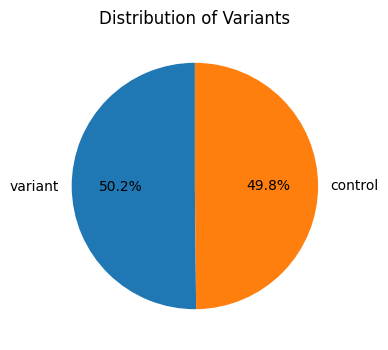

In [68]:
df_revenue["VARIANT_NAME"].value_counts()

promotion_distribution = df_revenue["VARIANT_NAME"].value_counts()

# Plotting the pie chart
plt.figure(figsize=(6, 4))
plt.pie(promotion_distribution, labels=promotion_distribution.index, autopct='%1.1f%%', startangle=90)
plt.title('Distribution of Variants')
plt.show()

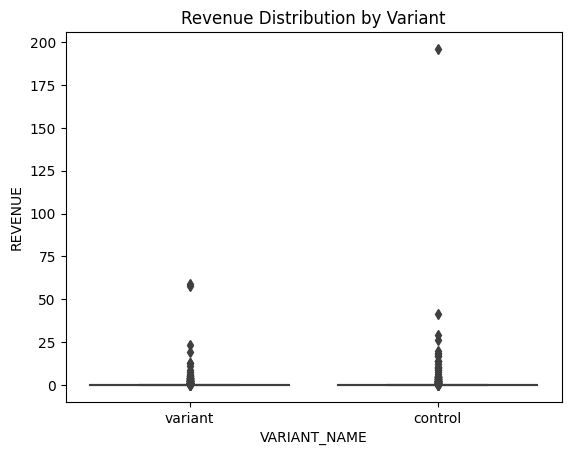

In [69]:
# Visualize Revenue distribution across variants
sns.boxplot(x="VARIANT_NAME", y="REVENUE", data=df_revenue)
plt.title("Revenue Distribution by Variant")
plt.show()

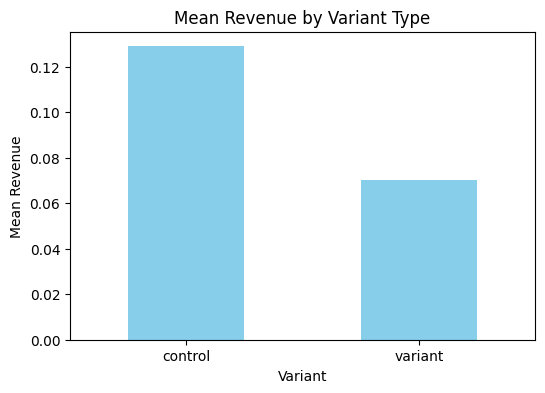

In [70]:
# Group by 'Variant' and calculate the mean for 'Revenue'
mean_sales_by_promotion = df_revenue.groupby('VARIANT_NAME')['REVENUE'].mean()

# Plotting the bar graph
plt.figure(figsize=(6, 4))
mean_sales_by_promotion.plot(kind='bar', color='skyblue')
plt.title('Mean Revenue by Variant Type')
plt.xlabel('Variant')
plt.ylabel('Mean Revenue')
plt.xticks(rotation=0)
plt.show()



**Hypothesis formulation:**

Null Hypothesis (H0): There is no statistical difference in terms of variant types

Alternative Hypothesis (H1): One of the variants is better than the other

**Normality Testing**

In [71]:
control = df_revenue.loc[df_revenue["VARIANT_NAME"]=="control"]
test = df_revenue.loc[df_revenue["VARIANT_NAME"]=="variant"]

test_stat,p_value = shapiro(control["REVENUE"])
print('Test Stat=%.4f,p-value=%.4f'%(test_stat,p_value))

Test Stat=0.0183,p-value=0.0000


With such a small p-value, you would reject the null hypothesis. This means that based on the Shapiro-Wilk test, there is strong evidence to suggest that the data is not normally distributed.

# **Non-parametric Testing**

**Mann-Whitney U Test (Wilcoxon Rank-Sum Test):**

Used to compare the distribution of two independent samples.
Appropriate when comparing two groups.

In [72]:
from scipy.stats import mannwhitneyu

result = mannwhitneyu(df_revenue[df_revenue['VARIANT_NAME'] == 'control']['REVENUE'],
                      df_revenue[df_revenue['VARIANT_NAME'] == "variant"]['REVENUE'])

print(result)


MannwhitneyuResult(statistic=12521564.0, pvalue=0.47825247965294926)


The p-value is relatively high (close to 0.5), suggesting that there is not enough evidence to reject the null hypothesis.
With such a p-value, you would typically fail to reject the null hypothesis.
Therefore, based on this test, you do not have sufficient evidence to claim that there is a significant difference in revenue between the variant types.

Conclusion:

Based on the tests, we do not have enough evidence to claim there is difference in revenue based on variant types, so both the variants have almost the same impact on revenue